In [1]:
import os
from os.path import exists

import anchor
import anchor.anchor_tabular

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error

from sklearn.svm import SVC
from sklearn.base import BaseEstimator, ClassifierMixin

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import joblib
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, f1_score, recall_score
from sklearn.inspection import DecisionBoundaryDisplay


import operator as op
from AnchorGeneration import *


In [2]:
data_path = "simulationVictor/"
res_path = data_path+"resultsPSR_Safe/"
results_anchorfile = "anchors-csr.csv"
feature_labels = ["SafetyMargin","Eta","Tau"]
true_output = "y_true"
cp_output = "y_conformal"
#model_output = "y_pred"

rules = pd.read_csv(res_path+results_anchorfile)

model = joblib.load(data_path+"CP_SVM_safe.sav")

test = pd.read_csv(data_path+"test_cp.csv")
y_test = np.array(test[true_output])
#y_model_test = np.array(test[model_output])
y_cp_test = np.array(test[cp_output])
X_test_df = test.drop([true_output,cp_output],axis = 1)
X_test = np.array(X_test_df)

In [3]:
test.describe()

,SafetyMargin,Eta,Tau,y_true,y_conformal
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.051040,0.502090,0.509766,0.092000,-0.154000
std,0.028420,0.297308,0.290281,0.996257,0.988565
min,0.000033,0.001484,0.001057,-1.000000,-1.000000
25%,0.027472,0.239229,0.255785,-1.000000,-1.000000
50%,0.051581,0.503088,0.519465,1.000000,-1.000000
75%,0.074577,0.771909,0.759454,1.000000,1.000000
max,0.099945,0.999287,0.998225,1.000000,1.000000


In [4]:
# visualize the anchors for all test set
rules

,Index,AnchorConditions,Coverage,Precision,AnchorOutput,ModelOutput,RealOutput
0,0,Tau > 0.76,0.2498,1.000000,-1.0,-1.0,-1.0
1,1,Tau <= 0.25,0.2481,0.916667,1.0,1.0,1.0
2,2,Tau > 0.76,0.2457,0.985075,-1.0,-1.0,-1.0
3,3,Tau <= 0.25,0.2469,0.923588,1.0,1.0,1.0
4,4,Tau <= 0.25,0.2540,0.915929,1.0,1.0,1.0
...,...,...,...,...,...,...,...
938,995,Eta <= 0.24,0.2451,0.748891,-1.0,-1.0,1.0
939,996,Eta > 0.75,0.2472,0.630856,1.0,1.0,1.0
940,997,Tau > 0.50,0.5004,0.856322,-1.0,-1.0,-1.0
941,998,Tau > 0.50,0.4986,0.893688,-1.0,-1.0,1.0


In [5]:
rules[rules["AnchorOutput"]==1]["AnchorConditions"].value_counts()

AnchorConditions
Tau <= 0.25            218
Tau <= 0.50            139
Eta > 0.75              43
SafetyMargin > 0.08     13
Tau <= 0.76              9
Eta > 0.49               1
Name: count, dtype: int64

In [6]:
model.get_params()

{'alpha': array([ 5.00152384e-01,  4.99955933e-01,  4.99933726e-01, ...,
         5.00076805e-01,  4.99889858e-01, -3.62958554e-05]),
 'b': array([-0.07530299]),
 'b_eps': 0.441391261831367,
 'eta': 0.3,
 'kernel': 'gaussian',
 'param': 0.5,
 'tau': array([[0.5]]),
 'solver': 'osqp'}

# Candidate selection

Text(0, 0.5, 'Count')

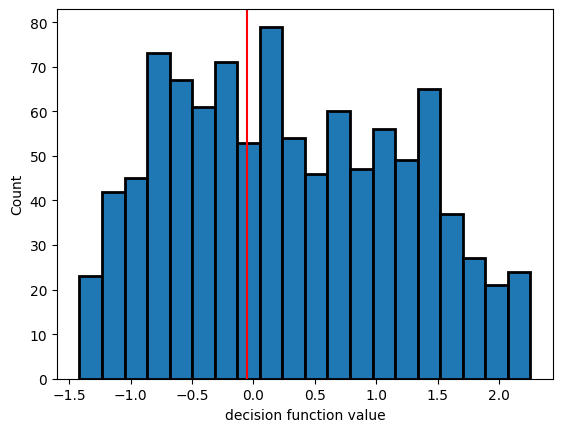

In [7]:
# distances of test points from decision boundary
d_test = model.decision_function(X_test)

plt.hist(d_test,bins = 20, edgecolor = "black",linewidth=2)
plt.gca().axvline(x=-0.05, color = "red")
plt.xlabel("decision function value")
plt.ylabel("Count")

In [8]:
min(d_test)

-1.4161405914814282

In [9]:
max(d_test)

2.255539516401589

In [10]:
model.b_eps

0.441391261831367

In [11]:
d_thresh = 0.05

border_points_idx = np.where((d_test < 0) & (abs(d_test) < d_thresh) & (y_cp_test == 1))[0]

print(f"# of candidate points: {len(border_points_idx)}")

# of candidate points: 11


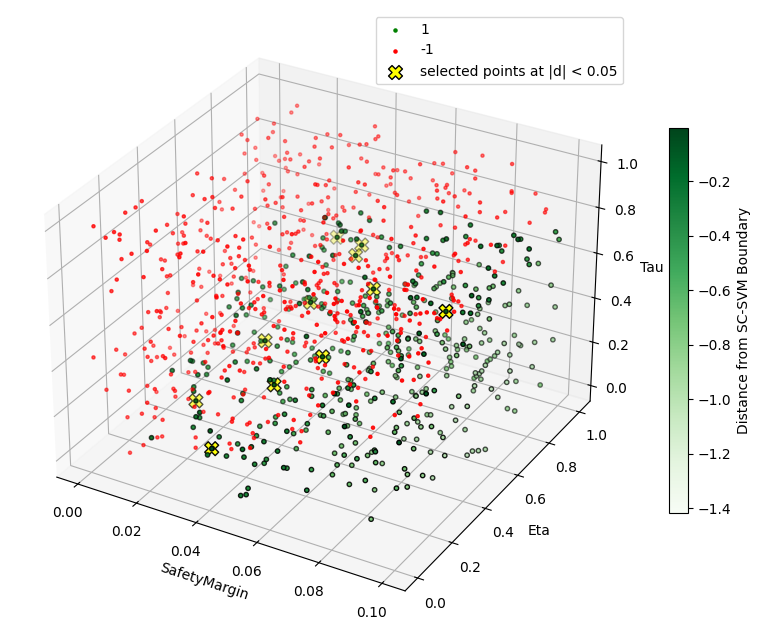

In [12]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(projection='3d')

sc0 = ax.scatter3D(X_test[:,0][y_cp_test == -1], X_test[:,1][y_cp_test == -1], X_test[:,2][y_cp_test == -1], s=5, c= "red")
scsafe = ax.scatter3D(X_test[:,0][y_cp_test == 1], X_test[:,1][y_cp_test == 1], X_test[:,2][y_cp_test == 1], s=5, c= "green")

sc1 = ax.scatter3D(X_test[:,0][y_cp_test == 1], X_test[:,1][y_cp_test == 1], X_test[:,2][y_cp_test == 1], s=10, c=d_test[y_cp_test == 1], cmap = "Greens", edgecolors = "k")

sc2 = ax.scatter3D(X_test[list(border_points_idx),0],X_test[list(border_points_idx),1], X_test[list(border_points_idx),2],s=100, marker = 'X', facecolors="yellow", edgecolors="k")


ax.set_xlabel("SafetyMargin")
ax.set_ylabel("Eta")
ax.set_zlabel("Tau")



ax.legend([scsafe, sc0,sc2], ["1","-1",f"selected points at |d| < {d_thresh}"], loc="upper right")
plt.colorbar(sc1, label = "Distance from SC-SVM Boundary", shrink = 0.5)

plt.show()

# Select the anchors for the candidate points

In [13]:
rule_cand_idx = np.array(rules[rules["Index"].isin(border_points_idx)==True].index)

In [14]:
# get rules generated on the selected boundary points
rules_candidates = rules.iloc[rule_cand_idx,:]

In [15]:
# focus on non collision class (label +1)
rules_noncoll = rules_candidates[rules_candidates["AnchorOutput"] == 1]
# '''
# # define a threshold for filtering on covering
# covering_threshold = 0.1

# rules_selected = rules_noncoll[rules_noncoll["Coverage"]>= covering_threshold]

# rules_selected = rules_selected.sort_values(by = ["Coverage"], axis = 0, ascending = False)

# rules_selected
# '''

In [16]:
rules_noncoll["AnchorConditions"].value_counts()

AnchorConditions
Tau <= 0.50            4
Eta > 0.75             3
Tau <= 0.25            2
SafetyMargin > 0.08    1
Tau <= 0.76            1
Name: count, dtype: int64

# Performance Evaluation


In [17]:
def evaluate_rules(data, tuned_rules, output):
    predictions_all = []
    for i, rule in tuned_rules.iterrows():
        pred_rule = []
        tptot = 0
        tntot = 0
        fntot = 0
        fptot = 0
        tuned_antecedent = rule['AnchorConditions'].strip()
        print(f"rule: {tuned_antecedent}")
        for _, row in data.iterrows():
            y_row = row[output]
            tp = 0
            tn = 0
            fn = 0
            fp = 0
            # check if the point row satifies rule 
            if evaluate_rule_conditions(row, tuned_antecedent):
                # rule is satisfied
                satisfied = True
                pred_rule.append(1)
            else:
                satisfied = False
                pred_rule.append(-1)
    
            
            if satisfied and y_row == 1:
                tp=1
            elif satisfied and y_row == -1:
                fp=1
            elif not satisfied and y_row == -1:
                tn=1
            
            elif not satisfied and y_row == 1:
                fn=1
            predictions_all.append(pred_rule)
            tptot+=tp
            tntot+=tn
            fptot+=fp
            fntot+=fn

        
        print(f"tp = {tptot}, tn = {tntot}, fp = {fptot}, fn = {fntot}")
        prec = tptot / (tptot+fptot)
        cov = tptot/(tptot+fntot)
        acc = (tptot+tntot)/(tptot+tntot+fptot+fntot)
        f1score = (2*tptot)/(2*tptot+fptot+fntot)
        err = fptot/(tntot+fptot)
        print(f"precision: {prec}, covering: {cov}, error: {err}, accuracy: {acc}, f1: {f1score}\n")          

    return predictions_all


def evaluate_rule_conditions(row, condition_part):

    # Checks if any of the conditions in the rule are satisfied
    if all(check_condition(row, part) for part in condition_part.split(" AND ")):
        return True  # Return True if all conditions in the rule are satisfied
    
    return False  # Return False if any of the conditions in the rule is not satisfied


def check_condition(row, condition_part):
    # Check if a single condition part is satisfied
    
    parts = [part.strip('()') for part in condition_part.split()]
    #print("parts: ", parts)
    if len(parts) == 3:
        column, op, value = parts
        return eval(f"{row[column]} {op} {value}")
    # handle the case of a 2-thresholds conditions of the kind: a < Column <= b
    elif len(parts) == 5:
        val1,op1,column,op2,val2 = parts
        # Use the original condition from the rule
        return eval(f"{val1} {op1} {row[column]} {op2} {val2}")        
    else:
        # Handle cases where the condition is not in the expected format
        pass

# SafetyMargin > 0.05 AND Tau <= 0.25 AND Eta > 0.25


In [18]:
rules_noncoll_unique = rules_noncoll.drop_duplicates(subset = "AnchorConditions")
rules_noncoll_unique

,Index,AnchorConditions,Coverage,Precision,AnchorOutput,ModelOutput,RealOutput
35,37,Eta > 0.75,0.2440,0.612258,1.0,1.0,1.0
331,351,Tau <= 0.25,0.2511,0.913478,1.0,1.0,-1.0
476,505,SafetyMargin > 0.08,0.2445,0.591482,1.0,1.0,1.0
484,513,Tau <= 0.50,0.4985,0.770328,1.0,1.0,1.0
849,902,Tau <= 0.76,0.7461,0.590511,1.0,1.0,1.0


# Evaluation on true labels

In [19]:
preds_by_rule = evaluate_rules(test, rules_noncoll_unique, true_output)

rule: Eta > 0.75
tp = 178, tn = 362, fp = 92, fn = 368
precision: 0.6592592592592592, covering: 0.326007326007326, error: 0.2026431718061674, accuracy: 0.54, f1: 0.4362745098039216

rule: Tau <= 0.25
tp = 190, tn = 404, fp = 50, fn = 356
precision: 0.7916666666666666, covering: 0.34798534798534797, error: 0.11013215859030837, accuracy: 0.594, f1: 0.48346055979643765

rule: SafetyMargin > 0.08
tp = 169, tn = 428, fp = 26, fn = 377
precision: 0.8666666666666667, covering: 0.30952380952380953, error: 0.05726872246696035, accuracy: 0.597, f1: 0.45614035087719296

rule: Tau <= 0.50
tp = 351, tn = 321, fp = 133, fn = 195
precision: 0.7252066115702479, covering: 0.6428571428571429, error: 0.29295154185022027, accuracy: 0.672, f1: 0.6815533980582524

rule: Tau <= 0.76
tp = 483, tn = 186, fp = 268, fn = 63
precision: 0.6431424766977364, covering: 0.8846153846153846, error: 0.5903083700440529, accuracy: 0.669, f1: 0.7447956823438705



# evaluation on safety checker labels

In [20]:
preds_by_rule_cp = evaluate_rules(test, rules_noncoll_unique, cp_output)

rule: Eta > 0.75
tp = 169, tn = 476, fp = 101, fn = 254
precision: 0.6259259259259259, covering: 0.39952718676122934, error: 0.17504332755632582, accuracy: 0.645, f1: 0.48773448773448774

rule: Tau <= 0.25
tp = 219, tn = 556, fp = 21, fn = 204
precision: 0.9125, covering: 0.5177304964539007, error: 0.036395147313691506, accuracy: 0.775, f1: 0.6606334841628959

rule: SafetyMargin > 0.08
tp = 114, tn = 496, fp = 81, fn = 309
precision: 0.5846153846153846, covering: 0.2695035460992908, error: 0.14038128249566725, accuracy: 0.61, f1: 0.36893203883495146

rule: Tau <= 0.50
tp = 357, tn = 450, fp = 127, fn = 66
precision: 0.737603305785124, covering: 0.8439716312056738, error: 0.22010398613518198, accuracy: 0.807, f1: 0.7872105843439912

rule: Tau <= 0.76
tp = 422, tn = 248, fp = 329, fn = 1
precision: 0.5619174434087882, covering: 0.9976359338061466, error: 0.5701906412478336, accuracy: 0.67, f1: 0.7189097103918228



**Evaluate the $\lor$ of the rules**

In [23]:
verified1 = (X_test[:,0] > 0.08) 
verified2 = (X_test[:,1] > 0.75) 
verified3 = (X_test[:,2] <= 0.25) 

verified_or = verified1|verified2|verified3

prec, cov, acc, fscore,err = ComputeMetricsForRule(verified_or, y_test)
print(f"precision: {prec}, covering: {cov}, accuracy: {acc}, f1: {fscore}, error: {err}")  

tp = 396, tn = 295, fp = 159, fn = 150
precision: 0.7135135135135136, covering: 0.7252747252747253, accuracy: 0.691, f1: 0.7193460490463215, error: 0.2864864864864865


In [24]:
verified1 = (X_test[:,0] > 0.08) 
verified2 = (X_test[:,1] > 0.75) 
verified3 = (X_test[:,2] <= 0.25) 

verified_or = verified1|verified2|verified3

prec, cov, acc, fscore,err = ComputeMetricsForRule(verified_or, y_cp_test)
print(f"precision: {prec}, covering: {cov}, accuracy: {acc}, f1: {fscore}, error: {err}")  

tp = 361, tn = 383, fp = 194, fn = 62
precision: 0.6504504504504505, covering: 0.8534278959810875, accuracy: 0.744, f1: 0.7382413087934561, error: 0.34954954954954953
